<a href="https://colab.research.google.com/github/SLVmain/ITMO_DL_in_practice_01/blob/main/f_2_1_plates_YOLO_annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Подготовка данных

данные взяты отсюда: https://www.kaggle.com/competitions/vkcv2022-contest-02-carplates
фото автомобилей с российскими номерами, 25 тысяч изображений, для выполнения задачи в дальнейшем случайным образом отобраны 2500 (2000 трейн и 500 валидация)

In [17]:
import json
import os
import re
from collections import Counter
from pathlib import Path
from PIL import Image
import random
import shutil
from tqdm import tqdm
import cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Polygon

In [8]:
!mkdir data

In [2]:
%cd data

/content/data


In [3]:
%pwd

'/content/data'

In [9]:
#download data from yandex disk
!wget -O /content/data/vk_plates.zip https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/NANSgQklgRElog

--2022-10-04 21:03:39--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/NANSgQklgRElog
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/5f627f60caec02eb61ab5bfcdf84f3db5a41f6d2263fddbbacddabd6235553f9/633cd7ec/_Es8VZKUcDX9pScl2Gn8MITWLBSxqzqqi9PcGS-DNXqdkmtJRkYTNX4HTJnqKd1RigaHz1IA0PfBklVim3aoiA%3D%3D?uid=0&filename=vkcv2022-contest-02-carplates.zip&disposition=attachment&hash=YJMV/dJyq0J1iG61oRvRcHPqd9bS4Tml8Ua89JaOB99FdTujuTQAitVmlVEmBc5mq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=16238026&fsize=6480287422&hid=97f05711a11dc5d9836306cc4e39e2e5&media_type=compressed&tknv=v2 [following]
--2022-10-04 21:03:40--  https://downloader.disk.yandex.ru/disk/5f627f60caec02eb61ab5bfcdf84f3db5a41f6d2263fddbbacddabd6235553f9/633cd7ec/_Es8VZKU

In [10]:
!unzip -q /content/data/vk_plates.zip -d /content/data

In [7]:
train_path = '/content/data/train'

##Первый взгляд на данные

In [11]:
class VK_PLATES:
    data_dir = Path("/content/data/data")
    train_img_dir = data_dir / "train"
    test_img_dir = data_dir / "test"
    train_json_path = data_dir / "train.json"

In [13]:
#количество
print(len(os.listdir(VK_PLATES.train_img_dir)))
print(len(os.listdir(VK_PLATES.test_img_dir)))

25633
3157


In [14]:
#какие расширения
print("File extensions in train:")
for ext, count in Counter([filename.rsplit('.', 1)[-1] for filename in os.listdir(VK_PLATES.train_img_dir)]).most_common():
        print(f"\t{ext}:\t{count}")

print("File extenions in test:")
for ext, count in Counter([filename.rsplit('.', 1)[-1] for filename in os.listdir(VK_PLATES.test_img_dir)]).most_common():
    print(f"\t{ext}:\t{count}")

File extensions in train:
	jpg:	17929
	bmp:	7704
File extenions in test:
	jpg:	2225
	bmp:	833
	jpeg:	51
	png:	41
	JPG:	6
	webp:	1


In [15]:
#загрузка файла с аннотациями
with open(VK_PLATES.train_json_path, 'r') as f_in:
    train_json = json.load(f_in)

In [16]:
train_df = pd.DataFrame(train_json).explode("nums")
train_df = pd.concat([train_df.drop(columns="nums"), train_df['nums'].apply(pd.Series)], axis=1)
train_df['file'] = train_df['file'].str.split("/").str[1]
train_df

,file,box,text
0,0.jpg,"[[180, 889], [596, 951], [598, 1056], [185, 983]]",B060BB125
1,1.jpg,"[[794, 661], [1004, 618], [1009, 670], [799, 7...",M938OX116
1,1.jpg,"[[944, 268], [995, 267], [994, 283], [942, 283]]",H881OA116
2,2.jpg,"[[286, 603], [346, 606], [346, 621], [285, 616]]",A549XA163
3,3.jpg,"[[217, 486], [489, 487], [488, 580], [204, 570]]",O934MO190
...,...,...,...
25628,25628.jpg,"[[209, 655], [443, 661], [439, 721], [201, 710]]",T252TO150
25629,25629.bmp,"[[205, 158], [287, 165], [288, 189], [205, 181]]",B240PB35
25630,25630.jpg,"[[621, 388], [796, 378], [801, 417], [626, 431]]",K607AP199
25631,25631.bmp,"[[379, 199], [448, 197], [450, 215], [379, 214]]",T454HK35


In [22]:
#посмотрим фото и нарисуем аннотации

img_dir = '/content/data/data/train/'

def show_sample(img_dir: Path, info_df=None, nrows=3, ncols=3):
    sample_imgs = np.random.choice(os.listdir(img_dir), nrows*ncols)

    plt.figure(figsize=(5*nrows, 5*ncols))
    
    for i, img_filename in enumerate(sample_imgs):
        
        plt.subplot(nrows, ncols, i+1)
        
        img = cv2.imread(img_dir + img_filename) #Image.open
        plt.imshow(img)
        
        if info_df is not None:
            
            boxes = info_df.loc[info_df['file'] == img_filename, 'box']
            
            for box in boxes.values:
                plt.gca().add_patch(Polygon(box, fill=False, color='r'))

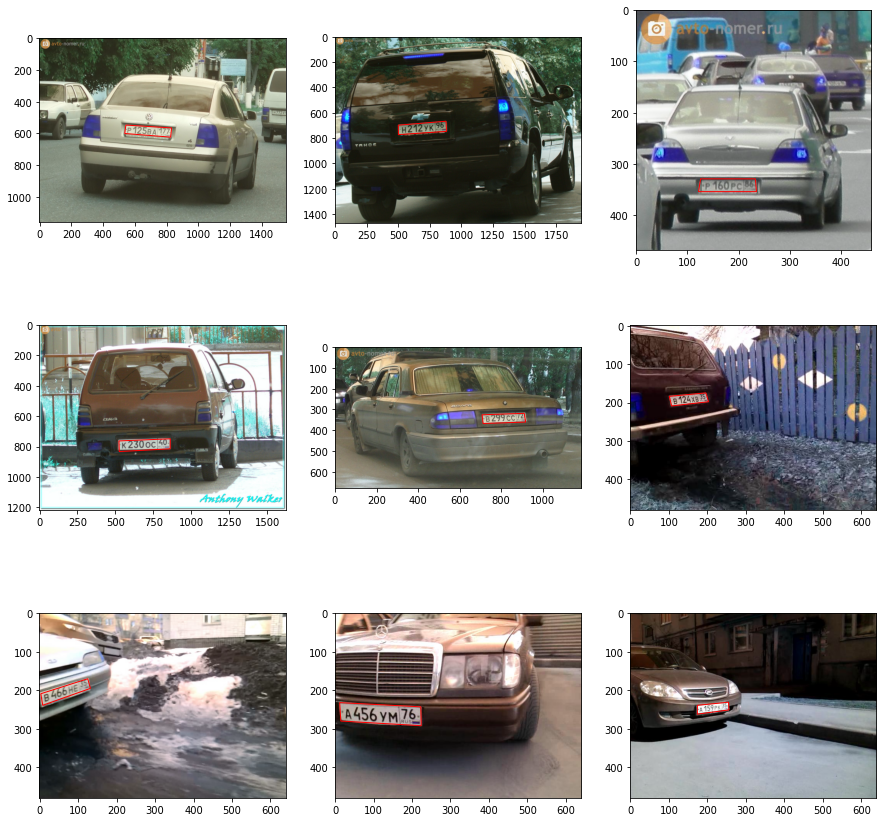

In [23]:
show_sample(img_dir, train_df)

Для обучения YOLO требуется от 1500 данных, оставим только лучшие по качеству изображения: в трейне и тесте - только jpg 

In [26]:
cd /content/data/data/test

/content/data/data/test


In [27]:
!rm  *.bmp *.jpeg *.png *.JPG *.webp

In [29]:
cd /content/data/data/train

/content/data/data/train


In [30]:
!rm  *.bmp

In [31]:
print("File extensions in train:")
for ext, count in Counter([filename.rsplit('.', 1)[-1] for filename in os.listdir(VK_PLATES.train_img_dir)]).most_common():
        print(f"\t{ext}:\t{count}")

print("File extenions in test:")
for ext, count in Counter([filename.rsplit('.', 1)[-1] for filename in os.listdir(VK_PLATES.test_img_dir)]).most_common():
    print(f"\t{ext}:\t{count}")

File extensions in train:
	jpg:	17929
File extenions in test:
	jpg:	2225


In [ ]:
#check sizes
from tqdm import tqdm
folder = '/content/data/data/train'
sizes_list = []
for file_name in tqdm(os.listdir(folder)):
    source = folder + file_name
    s = Image.open(source).size
    sizes_list.append(s)

s_set = set(sizes_list)
print(s_set)

100%|██████████| 17929/17929 [00:25<00:00, 708.10it/s] 

{(1913, 1361), (1515, 1117), (1350, 1054), (1024, 486), (1352, 979), (1135, 936), (800, 757), (1600, 1204), (530, 418), (1711, 1248), (1601, 1201), (1687, 1115), (1153, 928), (1796, 1246), (1201, 924), (1852, 1417), (1600, 1106), (1340, 1057), (1760, 1320), (1865, 1350), (1539, 1233), (1000, 762), (1676, 1070), (847, 628), (1528, 1200), (1990, 1470), (1700, 1168), (1500, 898), (737, 618), (1146, 774), (1071, 837), (1435, 1001), (1793, 1279), (1111, 580), (744, 526), (1024, 576), (1224, 824), (645, 472), (1000, 807), (1580, 1200), (1024, 767), (1300, 1032), (1802, 1270), (787, 651), (1124, 928), (1214, 806), (1657, 1207), (754, 746), (1632, 1199), (836, 552), (1480, 908), (598, 603), (1731, 1205), (1604, 1101), (1309, 1143), (1200, 1135), (1205, 1030), (1060, 799), (1242, 678), (948, 1041), (1998, 1405), (1558, 1374), (867, 695), (1065, 816), (1507, 1203), (1390, 1200), (1069, 889), (1584, 1059), (704, 487), (1777, 1250), (1372, 942), (2000, 1423), (1850, 1386), (1390, 1059), (1200, 839

In [ ]:
len(s_set)

10068

всего больше 10 тыс. размеров

посмотрим аннотации

In [32]:
train_df

,file,box,text
0,0.jpg,"[[180, 889], [596, 951], [598, 1056], [185, 983]]",B060BB125
1,1.jpg,"[[794, 661], [1004, 618], [1009, 670], [799, 7...",M938OX116
1,1.jpg,"[[944, 268], [995, 267], [994, 283], [942, 283]]",H881OA116
2,2.jpg,"[[286, 603], [346, 606], [346, 621], [285, 616]]",A549XA163
3,3.jpg,"[[217, 486], [489, 487], [488, 580], [204, 570]]",O934MO190
...,...,...,...
25628,25628.jpg,"[[209, 655], [443, 661], [439, 721], [201, 710]]",T252TO150
25629,25629.bmp,"[[205, 158], [287, 165], [288, 189], [205, 181]]",B240PB35
25630,25630.jpg,"[[621, 388], [796, 378], [801, 417], [626, 431]]",K607AP199
25631,25631.bmp,"[[379, 199], [448, 197], [450, 215], [379, 214]]",T454HK35


In [33]:
train_df.drop('text', axis=1, inplace=True)

In [34]:
train_df.head()

,file,box
0,0.jpg,"[[180, 889], [596, 951], [598, 1056], [185, 983]]"
1,1.jpg,"[[794, 661], [1004, 618], [1009, 670], [799, 7..."
1,1.jpg,"[[944, 268], [995, 267], [994, 283], [942, 283]]"
2,2.jpg,"[[286, 603], [346, 606], [346, 621], [285, 616]]"
3,3.jpg,"[[217, 486], [489, 487], [488, 580], [204, 570]]"


напишем функции для пересчета координат, нам нужны только xmin, xmax, ymin, ymax

In [35]:
def xmin(x):
    return min(x[0][0], x[3][0])

In [36]:
def xmax(x):
    return max(x[1][0], x[2][0])

In [37]:
def ymin(x):
    return min(x[0][1], x[3][1])

In [38]:
def ymax(x):
    return max(x[1][1], x[2][1])

In [39]:
train_df["xmin"] = train_df["box"].apply(xmin)
train_df["xmax"] = train_df["box"].apply(xmax)
train_df["ymin"] = train_df["box"].apply(ymin)
train_df["ymax"] = train_df["box"].apply(ymax)
train_df.head()

,file,box,xmin,xmax,ymin,ymax
0,0.jpg,"[[180, 889], [596, 951], [598, 1056], [185, 983]]",180,598,889,1056
1,1.jpg,"[[794, 661], [1004, 618], [1009, 670], [799, 7...",794,1009,661,670
1,1.jpg,"[[944, 268], [995, 267], [994, 283], [942, 283]]",942,995,268,283
2,2.jpg,"[[286, 603], [346, 606], [346, 621], [285, 616]]",285,346,603,621
3,3.jpg,"[[217, 486], [489, 487], [488, 580], [204, 570]]",204,489,486,580


In [40]:
train_df.drop(['box'], axis=1, inplace=True)
train_df.head()

,file,xmin,xmax,ymin,ymax
0,0.jpg,180,598,889,1056
1,1.jpg,794,1009,661,670
1,1.jpg,942,995,268,283
2,2.jpg,285,346,603,621
3,3.jpg,204,489,486,580


In [41]:
import gc
gc.collect()

22936

In [42]:
#для нормализации аннотаций нужно вытащить размеры файлов
folder = '/content/data/data/train/'
width = []
height = []
file_name = []
count=0
from tqdm import tqdm
for name in tqdm(os.listdir(folder)): #train_df['file'].to_list()
    try:
        f_name = folder+name
        size_ = Image.open(f_name).size
        width.append(size_[0])
        height.append(size_[1])
        file_name.append(name)
        count +=1
    except:
        print(1)
        #pass  
print(f'Procecced {count} files') 

100%|██████████| 17929/17929 [00:01<00:00, 9816.00it/s] 

Procecced 17929 files


In [43]:
#создадим таблицу с размерами файлов
intermediate_dictionary = {'file':file_name, 'width':width, 'height':height}

df1 = pd.DataFrame(intermediate_dictionary)
df1.head()

,file,width,height
0,17233.jpg,598,644
1,11252.jpg,1198,1034
2,2215.jpg,1200,800
3,7657.jpg,1600,1200
4,4324.jpg,1600,1062


In [44]:
train_df.head()

,file,xmin,xmax,ymin,ymax
0,0.jpg,180,598,889,1056
1,1.jpg,794,1009,661,670
1,1.jpg,942,995,268,283
2,2.jpg,285,346,603,621
3,3.jpg,204,489,486,580


In [45]:
#соединим таблицу в одну по имени файла
df = train_df.merge(df1, how='right', on='file')
df

,file,xmin,xmax,ymin,ymax,width,height
0,17233.jpg,221,350,388,413,598,644
1,11252.jpg,208,350,486,548,1198,1034
2,2215.jpg,353,608,374,425,1200,800
3,7657.jpg,491,758,512,572,1600,1200
4,4324.jpg,1291,1498,775,783,1600,1062
...,...,...,...,...,...,...,...
18873,23307.jpg,1463,1740,1030,1087,1997,1498
18874,1044.jpg,653,968,603,673,1600,1200
18875,3718.jpg,316,482,642,673,1159,913
18876,3718.jpg,1057,1122,564,583,1159,913


In [46]:
df.sort_values(by=['file']).head()

,file,xmin,xmax,ymin,ymax,width,height
16280,0.jpg,180,598,889,1056,1733,1396
8779,1.jpg,942,995,268,283,1200,908
8778,1.jpg,794,1009,661,670,1200,908
7582,10.jpg,95,214,368,434,800,600
9664,100.jpg,297,460,704,742,1400,1050


In [47]:
#нормируем (делим на ширину и высоту)
df.xmin = df.xmin / df.width
df.xmax = df.xmax / df.width
df.ymin = df.ymin / df.height
df.ymax = df.ymax / df.height

In [48]:
df.drop(['width', 'height'], axis=1, inplace=True)
df

,file,xmin,xmax,ymin,ymax
0,17233.jpg,0.369565,0.585284,0.602484,0.641304
1,11252.jpg,0.173623,0.292154,0.470019,0.529981
2,2215.jpg,0.294167,0.506667,0.467500,0.531250
3,7657.jpg,0.306875,0.473750,0.426667,0.476667
4,4324.jpg,0.806875,0.936250,0.729755,0.737288
...,...,...,...,...,...
18873,23307.jpg,0.732599,0.871307,0.687583,0.725634
18874,1044.jpg,0.408125,0.605000,0.502500,0.560833
18875,3718.jpg,0.272649,0.415876,0.703176,0.737130
18876,3718.jpg,0.911993,0.968076,0.617744,0.638554


In [49]:
#Добавляем нужные колонки для YOLO
df['classNumber'] = ''
df['centre x'] = ''
df['centre y'] = ''
df['width'] = ''
df['height'] = ''

In [50]:
df.columns

Index(['file', 'xmin', 'xmax', 'ymin', 'ymax', 'classNumber', 'centre x',
       'centre y', 'width', 'height'],
      dtype='object')

In [51]:
#вычисляем нужные данные для YOLO
df['classNumber'] = 0

# Calculate centre x and centre y values
df['centre x'] = (df['xmax'] + df['xmin']) / 2
df['centre y'] = (df['ymax'] + df['ymin']) / 2

# Calculate width and height values
df['width'] = (df['xmax'] - df['xmin'])
df['height'] = (df['ymax'] - df['ymin'])

#Generate the dataframe with YOLO required values
YOLO_values = df.loc[:,['file','classNumber','centre x','centre y','width','height']].copy()
YOLO_values.head() 

,file,classNumber,centre x,centre y,width,height
0,17233.jpg,0,0.477425,0.621894,0.215719,0.038820
1,11252.jpg,0,0.232888,0.500000,0.118531,0.059961
2,2215.jpg,0,0.400417,0.499375,0.212500,0.063750
3,7657.jpg,0,0.390313,0.451667,0.166875,0.050000
4,4324.jpg,0,0.871563,0.733522,0.129375,0.007533


In [52]:
!mkdir /content/data/data/labels/

создаем для каждой картинки текстовый файл нужного формата для YOLO

In [53]:
image_path = '/content/data/data/train/'
label_path = '/content/data/data/labels/'
os.chdir(image_path) # переход с папку с картинками

#перебор файлов в ветке
for current_dir , dirs, files in os.walk('.'):
  
    for f in files:
        
        YOLO_file = YOLO_values.loc[YOLO_values['file'] == f]

        #копируем df
        df0 = YOLO_file.loc[:, ['classNumber','centre x','centre y','width','height']].copy()
        
        save_path = label_path + f[:-4] + '.txt'

        # создаем текстовый файл с нужными для YOLO данными
        df0.to_csv(save_path, header=False, index=False,sep=' ')

In [54]:
#Проверка
len(os.listdir(image_path)) == len(os.listdir(label_path))

True

создадим датасет на 2000 трейн и 500 валид

In [55]:
!mkdir /content/small_data
!mkdir /content/small_data/train
!mkdir /content/small_data/train/images
!mkdir /content/small_data/train/labels

In [56]:
#сделаем уменьшенный датасет 2500 
src_train_img = '/content/data/data/train'
img_names = os.listdir(src_train_img)

src_train_lbl = '/content/data/data/labels'
label_names  = os.listdir(src_train_lbl)

small_train_img = '/content/small_data/train/images'
small_train_lbl = '/content/small_data/train/labels'

img_names = [x[:-4] for x in os.listdir(src_train_img)]
label_names = [x[:-4] for x in os.listdir(src_train_lbl)]

small_names = random.sample(img_names, 2500)

for i, name in tqdm(enumerate(small_names), total=len(small_names), desc='Выделение 2500'):
    shutil.move(os.path.join(src_train_img, name + '.jpg'), os.path.join(small_train_img, name + '.jpg'))
    shutil.move(os.path.join(src_train_lbl, name + '.txt'), os.path.join(small_train_lbl, name + '.txt'))

Выделение 2500: 100%|██████████| 2500/2500 [00:00<00:00, 10938.45it/s]


In [57]:
len(os.listdir(small_train_img))

2500

In [58]:
len(os.listdir(small_train_img)) == len(os.listdir(small_train_lbl))

True